## Estimating statistical errror bars with Jackknife resampling

This example shows how to extract the second Renyi entropy $S_2=\mathrm{Tr}(\rho^2)$ and the associated error bars. We use two methods. First, we present the standard Jackknife code which can be applied to any estimator. Second, we show how to use specialized code, provided by the get_trace_moment function, which optimize Jackknife for U-statistics and avoids usual resampling overhead.


In [6]:
using RandomMeas

First we load in memory a random quantum state and calculates the purities accross different cuts

In [7]:
N  = 6 #number of qubits
χ = 2^(N÷2) #a large bond-dimension to consider a typical random state
ξ = siteinds("Qubit", N)
ψ = random_mps(ξ; linkdims=χ);

S = [-log2(get_trace_moment(ψ,2,collect(1:NA))) for NA in 1:N] 
println("Entropies ", S);

Entropies [0.7084643318523388, 1.2594486915629697, 1.7650675582853241, 1.6409480751926346, 0.991220129172322, -1.2813706015259665e-15]


Then we sample randomized measurements 

In [8]:
using ProgressMeter

ITensors.disable_warn_order()
NU = 400
NM = 400
measurement_group = MeasurementGroup(ψ,NU,NM;mode="dense");

## Generic Jackknife code

[Jackknife resampling](https://en.wikipedia.org/wiki/Jackknife_resampling) provides a simple method to estimate statistical errors when estimating a physical quantity from a single dataset. The helper function below returns the Jackknife estimation of the statistical error for an estimator evaluated on a vector of $n_s$ samples. It requires $n_s$ evaluations of the estimator.  The Jackknife function provides also an approximate unbiased evaluation of the estimator. 

In [9]:
using Statistics

function jackknife(estimator::Function,samples::Vector)
    ns = length(samples)
    θ = zeros(Float64,ns)
    for i in 1:ns
        θ[i] = estimator(samples[1:end .!= i])
    end
    θ_est = ns*estimator(samples)-(ns-1)*mean(θ) #approximate unbiased estimator
    var_est = var(θ)* (ns - 1)^2 / ns #approximate statistical variance 
    return θ_est, sqrt(var_est)
end

jackknife (generic function with 1 method)

We can then apply this method for a 2nd Renyi entropy estimation based on batch shadows [Rath et al, PRX quantum 2023](https://doi.org/10.1103/PRXQuantum.4.010318).

Note that the above Jacknife method requires evaluating the estimator $n_s$ times, so we use here a small number $n_s=40$ of batch shadows to obtain a result in a reasonable time. 

In [21]:
number_of_ru_batches = 40 #number of batches
S_est = zeros(Float64,N)
σ= zeros(Float64,N)
@showprogress dt=1 for NA in 1:N

    reduced_measurement_group = reduce_to_subsystem(measurement_group,collect(1:NA))
    
    ρs = get_dense_shadows(reduced_measurement_group,number_of_ru_batches=number_of_ru_batches);

    estimator(x) = -log2(get_trace_moment(x, 2))

    S_est[NA], σ[NA] = jackknife(estimator,ρs)
end   

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


## Optimized Jackknife for U-statistics - avoiding the $n_s$ overhead

The function get_trace_moments provides also optimized routines for Jackknife variance and bias which avoids to the order $n_s$ overhead and provides thus a significant speed-up. 

In [22]:
number_of_ru_batches = 40 #number of batches
S_est_new = zeros(Float64,N)
σ_new = zeros(Float64,N)

@showprogress dt=1 for NA in 1:N

    reduced_measurement_group = reduce_to_subsystem(measurement_group,collect(1:NA))
    
    ρs = get_dense_shadows(reduced_measurement_group,number_of_ru_batches=number_of_ru_batches);

    S_est_new[NA], σ_new[NA] = get_trace_moment(ρs, 2, compute_renyi=true, compute_sem = true)
end   

@show S_est_new == S_est
@show  σ_new ==  σ

S_est_new == S_est = true
σ_new == σ = true


true

We now plot the results with error bars:

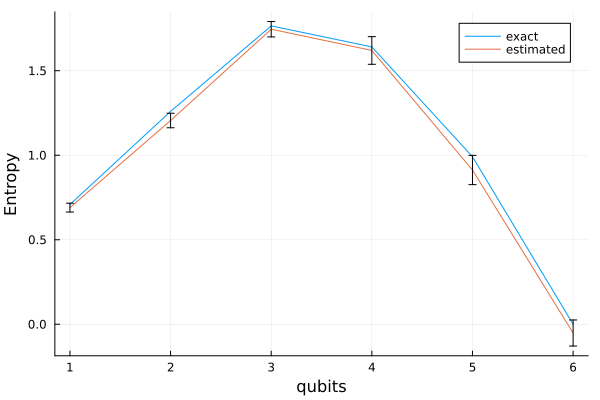

In [18]:
using Plots
plot(1:N,S,label="exact")
plot!(1:N,S_est,yerr = σ,label="estimated")

ylabel!("Entropy")
xlabel!("qubits")